In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data.csv')

In [3]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [4]:
def text_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
    
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

def remove_bracket(text):
    return re.sub('\[[^]]*\]', '', text)
    
def remove_special_characters(text):
    text = text.replace('-', ' ')  
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r"\n+", " ", text)
    return text

def remove_placeholders(text):
    return re.sub(r"\[\*\*.*?\*\*\]", "", text) 


def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    word_tokens = [word for word in word_tokens if word not in stop_words]
    text = ' '.join(word_tokens) # rejoin tokens into a single string
    return text

In [5]:
def clean_text(text):
    text = text_lowercase(text)
    text = remove_placeholders(text)
    text = remove_bracket(text)
    text = remove_numbers(text)
    text = remove_special_characters(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text) 
    return text       

In [6]:
df['TEXT'] = df['TEXT'].apply(clean_text)

In [7]:
def multi_label_accuracy(y_true, y_pred):
    """
    Calculate multi-label accuracy.
    
    Args:
        y_true (pd.DataFrame or np.ndarray): True binary labels.
        y_pred (pd.DataFrame or np.ndarray): Predicted binary labels.
        
    Returns:
        float: Multi-label accuracy.
    """
    # Convert DataFrame to NumPy array if needed
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    n_samples = y_true.shape[0]
    accuracy_sum = 0.0
    
    for i in range(n_samples):
        true_set = set(np.where(y_true[i])[0])
        pred_set = set(np.where(y_pred[i])[0])
        
        intersection = len(true_set & pred_set)
        union = len(true_set | pred_set)
        
        if union == 0:
            accuracy_sum += 1.0
        else:
            accuracy_sum += intersection / union
    
    return accuracy_sum / n_samples

In [8]:
X = df['TEXT']
y = df.iloc[:, 3:]

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("Number of Observations in the Data set:" , X.values.shape[0]) 
print("Number of Observations in Train set:", X_train.shape[0])
print("Number of Observations in Test set:" , X_test.shape[0])   

Number of Observations in the Data set: 48335
Number of Observations in Train set: 33834
Number of Observations in Test set: 14501


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=20000)

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [11]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(max_iter=1000, random_state=20)

In [12]:
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import f1_score

specific_labels = ['ICD9_V58', 'ICD9_427', 'ICD9_E87', 'ICD9_403', 'ICD9_401', 'ICD9_584',
                   'ICD9_414', 'ICD9_599', 'ICD9_585', 'ICD9_V45', 'ICD9_285', 'ICD9_V10',
                   'ICD9_428', 'ICD9_250', 'ICD9_038', 'ICD9_V30', 'ICD9_530', 'ICD9_272',
                   'ICD9_518', 'ICD9_276']
chains = []

for i in range(60):
    # Generate a unique random order of specific labels
    random_order = np.random.permutation(specific_labels)
    
    # Get the actual label names corresponding to the random order indices
    label_indices = [y_train.columns.get_loc(label) for label in random_order if label in y_train.columns]
    
    # Create a ClassifierChain with the random order of label indices
    chain = ClassifierChain(clf_lr, order=label_indices, random_state=i)
    chains.append(chain)

In [13]:
accuracies = []

for i, chain in enumerate(chains):
    # Train the model
    chain.fit(X_train_vectorized, y_train)
    
    # Get predictions for the test set
    y_pred = chain.predict(X_test_vectorized)
    
    accuracy = multi_label_accuracy(y_test, y_pred)    
    accuracies.append((chain.order, accuracy))
    
    print(f"Chain {i+1}: Accuracy = {accuracy}")

Chain 1: Accuracy = 0.47789716566524787
Chain 2: Accuracy = 0.47656801645664376
Chain 3: Accuracy = 0.47839537951340283
Chain 4: Accuracy = 0.473216498674225
Chain 5: Accuracy = 0.4734553094692026
Chain 6: Accuracy = 0.47738017667763655
Chain 7: Accuracy = 0.4781282358845972
Chain 8: Accuracy = 0.4700652047766018
Chain 9: Accuracy = 0.47644721083190755
Chain 10: Accuracy = 0.469047905235924
Chain 11: Accuracy = 0.4750985547947808
Chain 12: Accuracy = 0.4719816101919052
Chain 13: Accuracy = 0.47296212348363814
Chain 14: Accuracy = 0.47192794476516187
Chain 15: Accuracy = 0.47561268505685905
Chain 16: Accuracy = 0.46937079396478504
Chain 17: Accuracy = 0.4774481719959611
Chain 18: Accuracy = 0.47933656148003173
Chain 19: Accuracy = 0.47040258979004423
Chain 20: Accuracy = 0.47567571154909694
Chain 21: Accuracy = 0.4733955658659118
Chain 22: Accuracy = 0.4740458873165211
Chain 23: Accuracy = 0.4742874042224063
Chain 24: Accuracy = 0.47189114253713016
Chain 25: Accuracy = 0.481127939155832

In [14]:
# Display results
for idx, (order, accuracy) in enumerate(accuracies):
    order_str = ' - '.join(map(str, order))
    print(f"Chain {idx + 1}: Label Order: {order_str}, Accuracy: {accuracy:.4f}")

Chain 1: Label Order: 3 - 6 - 4 - 11 - 14 - 8 - 2 - 13 - 9 - 7 - 16 - 17 - 10 - 1 - 15 - 5 - 0 - 18 - 12 - 19, Accuracy: 0.4779
Chain 2: Label Order: 4 - 1 - 3 - 16 - 18 - 19 - 8 - 6 - 5 - 13 - 2 - 15 - 9 - 17 - 10 - 0 - 7 - 14 - 11 - 12, Accuracy: 0.4766
Chain 3: Label Order: 2 - 10 - 12 - 11 - 6 - 16 - 5 - 8 - 14 - 4 - 3 - 0 - 18 - 1 - 17 - 15 - 13 - 7 - 9 - 19, Accuracy: 0.4784
Chain 4: Label Order: 18 - 13 - 12 - 7 - 19 - 17 - 2 - 3 - 6 - 5 - 11 - 1 - 4 - 0 - 8 - 14 - 16 - 15 - 10 - 9, Accuracy: 0.4732
Chain 5: Label Order: 0 - 13 - 4 - 3 - 15 - 14 - 8 - 16 - 5 - 12 - 7 - 19 - 17 - 11 - 1 - 9 - 6 - 2 - 18 - 10, Accuracy: 0.4735
Chain 6: Label Order: 9 - 10 - 5 - 1 - 18 - 3 - 8 - 13 - 2 - 16 - 14 - 0 - 4 - 12 - 11 - 19 - 15 - 6 - 7 - 17, Accuracy: 0.4774
Chain 7: Label Order: 1 - 2 - 15 - 4 - 13 - 10 - 8 - 11 - 9 - 17 - 3 - 19 - 6 - 7 - 18 - 14 - 0 - 16 - 12 - 5, Accuracy: 0.4781
Chain 8: Label Order: 14 - 17 - 15 - 16 - 2 - 4 - 1 - 9 - 6 - 0 - 8 - 11 - 3 - 7 - 12 - 13 - 18 - 10 - 1

In [15]:
ml_accs = []

for idx, (order, accuracy) in enumerate(accuracies):
    ml_accs.append(accuracy)

In [16]:
ml_accs

[0.47789716566524787,
 0.47656801645664376,
 0.47839537951340283,
 0.473216498674225,
 0.4734553094692026,
 0.47738017667763655,
 0.4781282358845972,
 0.4700652047766018,
 0.47644721083190755,
 0.469047905235924,
 0.4750985547947808,
 0.4719816101919052,
 0.47296212348363814,
 0.47192794476516187,
 0.47561268505685905,
 0.46937079396478504,
 0.4774481719959611,
 0.47933656148003173,
 0.47040258979004423,
 0.47567571154909694,
 0.4733955658659118,
 0.4740458873165211,
 0.4742874042224063,
 0.47189114253713016,
 0.48112793915583263,
 0.4748070647793073,
 0.4745622584780217,
 0.4775080908907877,
 0.4780085939583532,
 0.47693038395834564,
 0.4717754960522697,
 0.47857379510282444,
 0.47466824708825167,
 0.4734577449881554,
 0.47769976510321743,
 0.47647550778455366,
 0.47248751897482894,
 0.47052885117242566,
 0.4781153028713527,
 0.4715926621976182,
 0.47081817520838726,
 0.4762957101476841,
 0.4725575531097546,
 0.4722705733110175,
 0.474844589223768,
 0.4714252205089036,
 0.477349890854

In [17]:
# Identify the best label order according to accuracy
best_order, best_accuracy = max(accuracies, key=lambda x: x[1])

print("Best Label Order:", best_order)
print("Best Accuracy:", best_accuracy)

Best Label Order: [18, 2, 10, 15, 8, 5, 4, 19, 14, 7, 16, 11, 13, 9, 17, 6, 1, 12, 0, 3]
Best Accuracy: 0.48112793915583263


In [18]:
best_label_order_names = [specific_labels[idx] for idx in best_order]
best_label_order_names

['ICD9_518',
 'ICD9_E87',
 'ICD9_285',
 'ICD9_V30',
 'ICD9_585',
 'ICD9_584',
 'ICD9_401',
 'ICD9_276',
 'ICD9_038',
 'ICD9_599',
 'ICD9_530',
 'ICD9_V10',
 'ICD9_250',
 'ICD9_V45',
 'ICD9_272',
 'ICD9_414',
 'ICD9_427',
 'ICD9_428',
 'ICD9_V58',
 'ICD9_403']

In [1]:
ml_accs = [0.47789716566524787, 0.47656801645664376, 0.47839537951340283, 0.473216498674225, 0.4734553094692026,
 0.47738017667763655, 0.4781282358845972, 0.4700652047766018, 0.47644721083190755, 0.469047905235924, 0.4750985547947808,
 0.4719816101919052, 0.47296212348363814, 0.47192794476516187, 0.47561268505685905, 0.46937079396478504, 0.4774481719959611,
 0.47933656148003173, 0.47040258979004423, 0.47567571154909694, 0.4733955658659118, 0.4740458873165211, 0.4742874042224063,
 0.47189114253713016, 0.48112793915583263, 0.4748070647793073, 0.4745622584780217, 0.4775080908907877, 0.4780085939583532,
 0.47693038395834564, 0.4717754960522697, 0.47857379510282444, 0.47466824708825167, 0.4734577449881554, 0.47769976510321743,
 0.47647550778455366, 0.47248751897482894, 0.47052885117242566, 0.4781153028713527, 0.4715926621976182, 0.47081817520838726,
 0.4762957101476841, 0.4725575531097546, 0.4722705733110175, 0.474844589223768, 0.4714252205089036, 0.4773498908549926,
 0.4723703082617984, 0.47681503035961154, 0.47807705008673723, 0.47350972275546277, 0.4716458151454005, 0.4780443578328186, 0.4796146969022951,
 0.47817157183666165, 0.4779955791360168, 0.4759134306949959, 0.4732921558209442, 0.4790534606762778, 0.4707482080516681]

In [2]:
ensemble_ml_acc = 0.4776908983368866

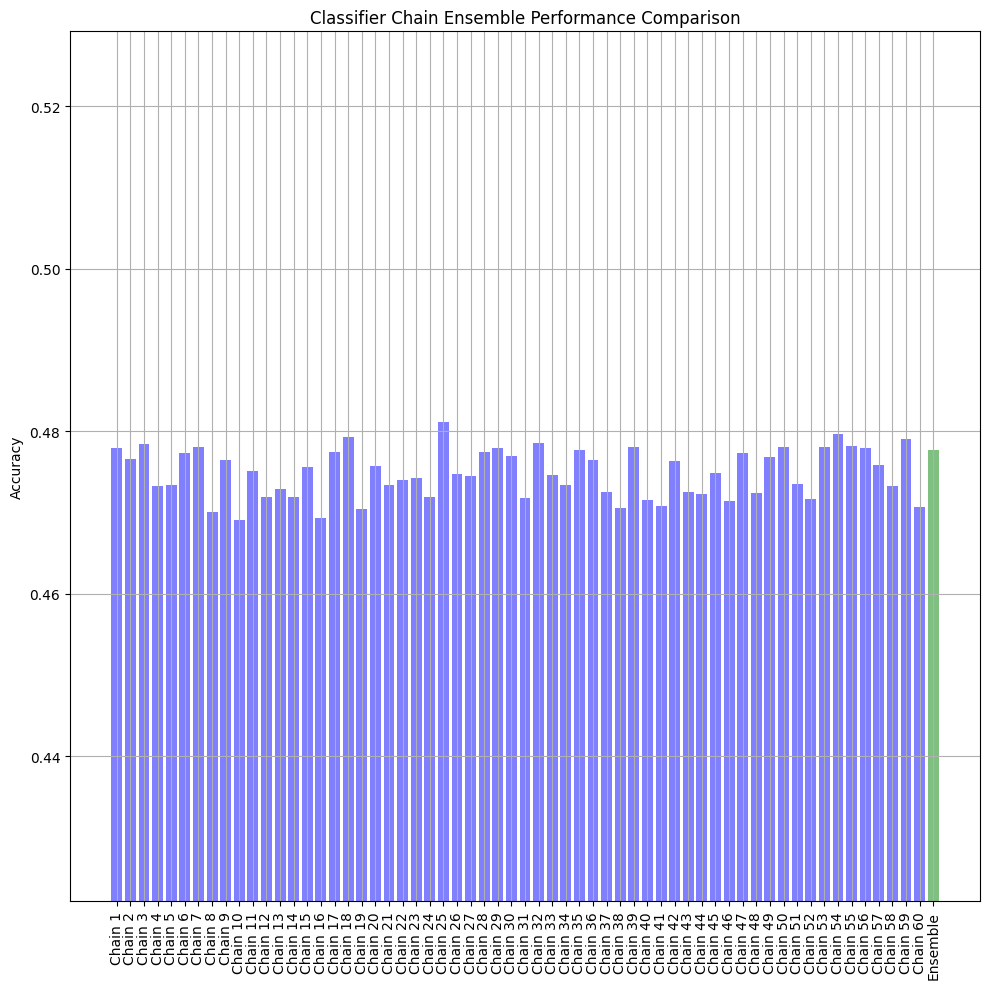

In [4]:
import matplotlib.pyplot as plt
import numpy as np

model_scores = ml_accs + [ensemble_ml_acc]

model_names = (
    "Chain 1", "Chain 2", "Chain 3", "Chain 4", "Chain 5", "Chain 6", "Chain 7", "Chain 8", "Chain 9", "Chain 10",
    "Chain 11", "Chain 12",  "Chain 13", "Chain 14",  "Chain 15",  "Chain 16",  "Chain 17",  "Chain 18",  "Chain 19",  "Chain 20",
    "Chain 21", "Chain 22", "Chain 23", "Chain 24", "Chain 25", "Chain 26", "Chain 27", "Chain 28", "Chain 29", "Chain 30",
    "Chain 31", "Chain 32",  "Chain 33",  "Chain 34",  "Chain 35",  "Chain 36",  "Chain 37",  "Chain 38",  "Chain 39",  "Chain 40",
    "Chain 41",  "Chain 42",  "Chain 43",  "Chain 44",  "Chain 45",  "Chain 46",  "Chain 47",  "Chain 48",  "Chain 49",  "Chain 50",
    "Chain 51",  "Chain 52",  "Chain 53",  "Chain 54",  "Chain 55",  "Chain 56",  "Chain 57",  "Chain 58",  "Chain 59",  "Chain 60",
    "Ensemble"
)

x_pos = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(True)
ax.set_title("Classifier Chain Ensemble Performance Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Accuracy")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["b"] * len(ml_accs) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()

plt.savefig("ecc.png")

plt.show()

In [20]:
y_pred_chains = np.array([chain.predict(X_test_vectorized) for chain in chains])
vote_counts = np.sum(y_pred_chains, axis=0)
vote_counts 

array([[ 0., 60.,  0., ...,  0.,  0.,  0.],
       [ 0.,  8.,  0., ...,  4.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0., 60.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  5., ...,  8.,  0.,  0.]])

In [21]:
num_chains = y_pred_chains.shape[0]

majority_threshold = num_chains / 2
y_pred_ensemble = (vote_counts >= majority_threshold).astype(int)

print(f"Ensemble Predictions: {y_pred_ensemble}")

Ensemble Predictions: [[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [22]:
y_pred_ensemble = np.array(y_pred_ensemble)

y_pred_ensemble

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, jaccard_score

ensemble_jaccard_micro = jaccard_score(y_test, y_pred_ensemble, average='micro') 
ensemble_jaccard_macro = jaccard_score(y_test, y_pred_ensemble, average='macro') 

ensemble_f1_score_micro = f1_score(y_test, y_pred_ensemble, average="micro")
ensemble_f1_score_macro = f1_score(y_test, y_pred_ensemble, average="macro")
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_hamming_loss = hamming_loss(y_test, y_pred_ensemble)
ensemble_ml_acc = multi_label_accuracy(y_test, y_pred_ensemble)

print(f"Ensemble Jaccard Score (micro): {ensemble_jaccard_micro}")
print(f"\nEnsemble Jaccard Score (macro): {ensemble_jaccard_macro}")
print(f"\nEnsemble F1 Score (micro): {ensemble_f1_score_micro}")
print(f"\nEnsemble F1 Score (macro): {ensemble_f1_score_macro}")
print(f"\nEnsemble Accuracy: {ensemble_accuracy}")
print(f"\nEnsemble Hamming Loss: {ensemble_hamming_loss}")
print(f"\nEnsemble Multi Label Accuracy: {ensemble_ml_acc}")

Ensemble Jaccard Score (micro): 0.46919075226444784

Ensemble Jaccard Score (macro): 0.4471612086156759

Ensemble F1 Score (micro): 0.6387063783804645

Ensemble F1 Score (macro): 0.5926803251267916

Ensemble Accuracy: 0.13212881870215848

Ensemble Hamming Loss: 0.12911868147024344

Ensemble Multi Label Accuracy: 0.4776908983368866
